# PG

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Hyperparameters
learning_rate = 0.0002
gamma = 0.98


class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.data = []

        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 2)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=0)
        return x

    def put_data(self, item):
        self.data.append(item)

    def train_net(self):
        R = 0
        self.optimizer.zero_grad()
        for r, prob in self.data[::-1]:
            R = r + gamma * R
            loss = -torch.log(prob) * R
            loss.backward()
        self.optimizer.step()
        self.data = []


def main():
    env = gym.make('CartPole-v1')
    pi = Policy()
    score = 0.0
    steps = []
    cache = []
    print_interval = 20

    for n_epi in range(10000):
        s = env.reset()
        step = 0
        done = False

        while not done:  # CartPole-v1 forced to terminates at 500 step.
            prob = pi(torch.from_numpy(s).float())
            m = Categorical(prob)
            a = m.sample()
            s_prime, r, done, info = env.step(a.item())
            pi.put_data((r, prob[a]))
            s = s_prime
            score += r
            step += 1
            
            if done:
                steps.append(step)
                break

        pi.train_net()

        if n_epi % print_interval == 0 and n_epi != 0:
            print("# of episode :{}, avg score : {}".format(
                n_epi, score/print_interval))
            cache.append(score/print_interval)
            score = 0.0
    env.close()
    
    return steps, cache

# PG-results

In [2]:
steps, cache = main()

# of episode :20, avg score : 22.3
# of episode :40, avg score : 24.25
# of episode :60, avg score : 21.45
# of episode :80, avg score : 21.35
# of episode :100, avg score : 29.9
# of episode :120, avg score : 28.65
# of episode :140, avg score : 32.8
# of episode :160, avg score : 27.75
# of episode :180, avg score : 29.1
# of episode :200, avg score : 27.45
# of episode :220, avg score : 25.45
# of episode :240, avg score : 25.25
# of episode :260, avg score : 32.5
# of episode :280, avg score : 37.8
# of episode :300, avg score : 31.5
# of episode :320, avg score : 33.6
# of episode :340, avg score : 35.45
# of episode :360, avg score : 36.6
# of episode :380, avg score : 41.65
# of episode :400, avg score : 47.0
# of episode :420, avg score : 34.4
# of episode :440, avg score : 38.75
# of episode :460, avg score : 37.45
# of episode :480, avg score : 40.45
# of episode :500, avg score : 38.8
# of episode :520, avg score : 38.05
# of episode :540, avg score : 49.7
# of episode :560,

# of episode :4340, avg score : 397.4
# of episode :4360, avg score : 370.4
# of episode :4380, avg score : 457.95
# of episode :4400, avg score : 407.15
# of episode :4420, avg score : 411.9
# of episode :4440, avg score : 392.45
# of episode :4460, avg score : 404.4
# of episode :4480, avg score : 387.8
# of episode :4500, avg score : 387.65
# of episode :4520, avg score : 312.5
# of episode :4540, avg score : 397.55
# of episode :4560, avg score : 367.75
# of episode :4580, avg score : 406.85
# of episode :4600, avg score : 392.7
# of episode :4620, avg score : 416.3
# of episode :4640, avg score : 404.1
# of episode :4660, avg score : 424.4
# of episode :4680, avg score : 365.3
# of episode :4700, avg score : 415.05
# of episode :4720, avg score : 429.15
# of episode :4740, avg score : 410.7
# of episode :4760, avg score : 467.95
# of episode :4780, avg score : 417.55
# of episode :4800, avg score : 444.25
# of episode :4820, avg score : 476.85
# of episode :4840, avg score : 433.6

# of episode :8600, avg score : 482.65
# of episode :8620, avg score : 482.8
# of episode :8640, avg score : 489.75
# of episode :8660, avg score : 495.4
# of episode :8680, avg score : 487.2
# of episode :8700, avg score : 500.0
# of episode :8720, avg score : 475.25
# of episode :8740, avg score : 479.85
# of episode :8760, avg score : 500.0
# of episode :8780, avg score : 500.0
# of episode :8800, avg score : 488.9
# of episode :8820, avg score : 497.55
# of episode :8840, avg score : 494.7
# of episode :8860, avg score : 486.35
# of episode :8880, avg score : 481.15
# of episode :8900, avg score : 500.0
# of episode :8920, avg score : 479.25
# of episode :8940, avg score : 500.0
# of episode :8960, avg score : 500.0
# of episode :8980, avg score : 480.85
# of episode :9000, avg score : 492.15
# of episode :9020, avg score : 500.0
# of episode :9040, avg score : 500.0
# of episode :9060, avg score : 473.75
# of episode :9080, avg score : 471.2
# of episode :9100, avg score : 475.65


# VG

In [3]:
import gym
import collections
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Hyperparameters
learning_rate = 0.0005
gamma = 0.98
buffer_limit = 50000
batch_size = 32


class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
            torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
            torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)


class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0, 1)
        else:
            return out.argmax().item()


def train(q, q_target, memory, optimizer):
    for i in range(10):
        s, a, r, s_prime, done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1, a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def main_():
    env = gym.make('CartPole-v1')
    q = Qnet()
    q_target = Qnet()
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()
    
    cache = []
    steps = []
    print_interval = 20
    score = 0.0
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)

    for n_epi in range(10000):
        epsilon = max(0.01, 0.08 - 0.01*(n_epi/200)
                      )  # Linear annealing from 8% to 1%
        s = env.reset()
        step = 0
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)
            s_prime, r, done, info = env.step(a)
            done_mask = 0.0 if done else 1.0
            memory.put((s, a, r/100.0, s_prime, done_mask))
            s = s_prime
            score += r
            step += 1
            
            if done:
                steps.append(step)
                break

        if memory.size() > 2000:
            train(q, q_target, memory, optimizer)

        if n_epi % print_interval == 0 and n_epi != 0:
            q_target.load_state_dict(q.state_dict())
            print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
                n_epi ,score/print_interval, memory.size(), epsilon*100))
            cache.append(score/print_interval)
            score = 0.0
    env.close()
    
    return steps , cache

# VG-results

In [4]:
steps_, cache_ = main_()

n_episode :20, score : 13.1, n_buffer : 261, eps : 7.9%
n_episode :40, score : 12.2, n_buffer : 506, eps : 7.8%
n_episode :60, score : 12.6, n_buffer : 757, eps : 7.7%
n_episode :80, score : 12.2, n_buffer : 1000, eps : 7.6%
n_episode :100, score : 11.9, n_buffer : 1239, eps : 7.5%
n_episode :120, score : 11.2, n_buffer : 1464, eps : 7.4%
n_episode :140, score : 12.2, n_buffer : 1707, eps : 7.3%
n_episode :160, score : 11.7, n_buffer : 1941, eps : 7.2%
n_episode :180, score : 21.4, n_buffer : 2370, eps : 7.1%
n_episode :200, score : 12.5, n_buffer : 2620, eps : 7.0%
n_episode :220, score : 16.1, n_buffer : 2943, eps : 6.9%
n_episode :240, score : 16.1, n_buffer : 3265, eps : 6.8%
n_episode :260, score : 17.1, n_buffer : 3608, eps : 6.7%
n_episode :280, score : 60.2, n_buffer : 4813, eps : 6.6%
n_episode :300, score : 99.5, n_buffer : 6804, eps : 6.5%
n_episode :320, score : 138.0, n_buffer : 9564, eps : 6.4%
n_episode :340, score : 188.3, n_buffer : 13330, eps : 6.3%
n_episode :360, sc

n_episode :2740, score : 220.3, n_buffer : 50000, eps : 1.0%
n_episode :2760, score : 189.3, n_buffer : 50000, eps : 1.0%
n_episode :2780, score : 189.2, n_buffer : 50000, eps : 1.0%
n_episode :2800, score : 269.4, n_buffer : 50000, eps : 1.0%
n_episode :2820, score : 270.6, n_buffer : 50000, eps : 1.0%
n_episode :2840, score : 244.8, n_buffer : 50000, eps : 1.0%
n_episode :2860, score : 259.9, n_buffer : 50000, eps : 1.0%
n_episode :2880, score : 245.6, n_buffer : 50000, eps : 1.0%
n_episode :2900, score : 282.4, n_buffer : 50000, eps : 1.0%
n_episode :2920, score : 267.8, n_buffer : 50000, eps : 1.0%
n_episode :2940, score : 300.5, n_buffer : 50000, eps : 1.0%
n_episode :2960, score : 262.2, n_buffer : 50000, eps : 1.0%
n_episode :2980, score : 244.8, n_buffer : 50000, eps : 1.0%
n_episode :3000, score : 183.1, n_buffer : 50000, eps : 1.0%
n_episode :3020, score : 201.7, n_buffer : 50000, eps : 1.0%
n_episode :3040, score : 290.8, n_buffer : 50000, eps : 1.0%
n_episode :3060, score :

n_episode :5440, score : 171.8, n_buffer : 50000, eps : 1.0%
n_episode :5460, score : 187.9, n_buffer : 50000, eps : 1.0%
n_episode :5480, score : 173.4, n_buffer : 50000, eps : 1.0%
n_episode :5500, score : 174.5, n_buffer : 50000, eps : 1.0%
n_episode :5520, score : 159.0, n_buffer : 50000, eps : 1.0%
n_episode :5540, score : 173.1, n_buffer : 50000, eps : 1.0%
n_episode :5560, score : 183.2, n_buffer : 50000, eps : 1.0%
n_episode :5580, score : 177.5, n_buffer : 50000, eps : 1.0%
n_episode :5600, score : 170.7, n_buffer : 50000, eps : 1.0%
n_episode :5620, score : 169.3, n_buffer : 50000, eps : 1.0%
n_episode :5640, score : 182.6, n_buffer : 50000, eps : 1.0%
n_episode :5660, score : 165.4, n_buffer : 50000, eps : 1.0%
n_episode :5680, score : 165.4, n_buffer : 50000, eps : 1.0%
n_episode :5700, score : 176.9, n_buffer : 50000, eps : 1.0%
n_episode :5720, score : 151.3, n_buffer : 50000, eps : 1.0%
n_episode :5740, score : 164.7, n_buffer : 50000, eps : 1.0%
n_episode :5760, score :

n_episode :8140, score : 439.4, n_buffer : 50000, eps : 1.0%
n_episode :8160, score : 389.1, n_buffer : 50000, eps : 1.0%
n_episode :8180, score : 465.9, n_buffer : 50000, eps : 1.0%
n_episode :8200, score : 455.7, n_buffer : 50000, eps : 1.0%
n_episode :8220, score : 400.6, n_buffer : 50000, eps : 1.0%
n_episode :8240, score : 427.2, n_buffer : 50000, eps : 1.0%
n_episode :8260, score : 431.6, n_buffer : 50000, eps : 1.0%
n_episode :8280, score : 411.2, n_buffer : 50000, eps : 1.0%
n_episode :8300, score : 449.4, n_buffer : 50000, eps : 1.0%
n_episode :8320, score : 456.4, n_buffer : 50000, eps : 1.0%
n_episode :8340, score : 473.3, n_buffer : 50000, eps : 1.0%
n_episode :8360, score : 455.3, n_buffer : 50000, eps : 1.0%
n_episode :8380, score : 469.6, n_buffer : 50000, eps : 1.0%
n_episode :8400, score : 491.2, n_buffer : 50000, eps : 1.0%
n_episode :8420, score : 438.8, n_buffer : 50000, eps : 1.0%
n_episode :8440, score : 431.1, n_buffer : 50000, eps : 1.0%
n_episode :8460, score :

In [34]:
cache.append(464.25)
cache_.append(473.7)

In [61]:
print(len(cache), len(cache_), len(steps), len(steps_))

500 500 10000 10000


In [112]:
refined_steps = []
refined_steps_ = []
for i in range(100):
    n = 100*i
    refined_steps.append(np.mean(steps[n:n+100]))
    refined_steps_.append(np.mean(steps_[n:n+100]))

In [143]:
from scipy.interpolate import make_interp_spline

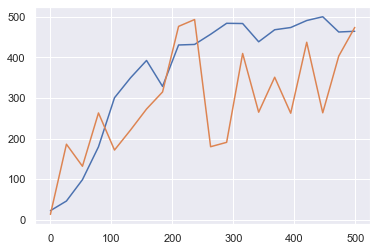

In [174]:
x = np.array(range(500))
y = new_cache

x_ = np.array(range(500))
y_ = new_cache_

xnew = np.linspace(x.min(), x.max(), 20)
xnew_ = np.linspace(x_.min(), x_.max(), 20)

spl = make_interp_spline(x, y, k=1)
spl_ = make_interp_spline(x_, y_, k=1)

y_smooth = spl(xnew)
y_smooth_ = spl_(xnew_)

In [90]:
new_cache = np.array(cache)
new_cache_ = np.array(cache_)

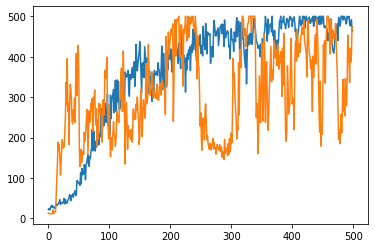

In [91]:
plt.plot(new_cache)
plt.plot(new_cache_)

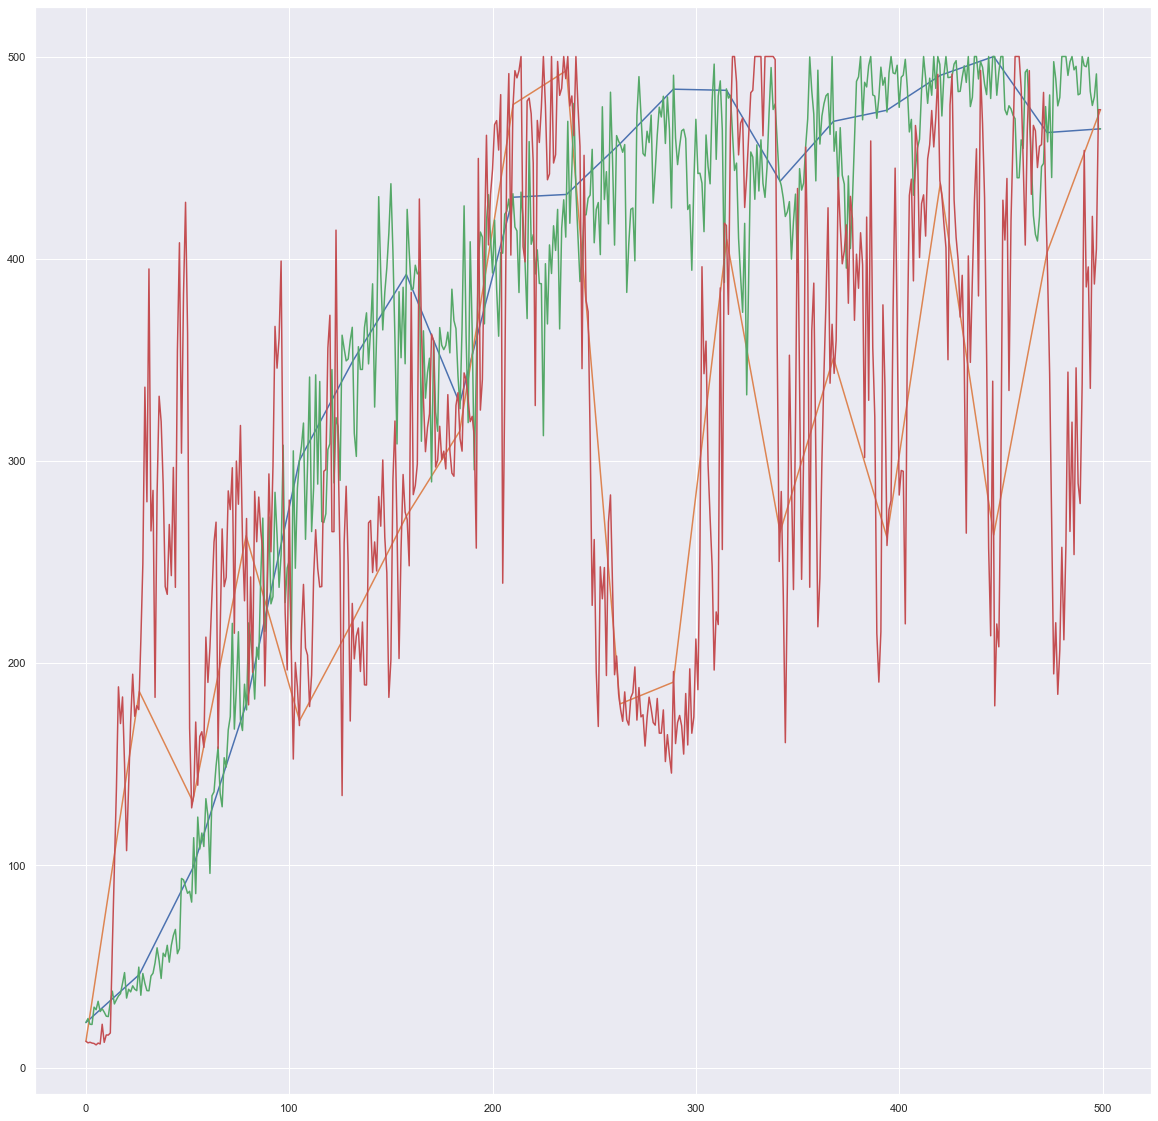

In [175]:
plt.figure(figsize=(20, 20))
plt.plot(xnew, y_smooth)
plt.plot(xnew_, y_smooth_)
plt.plot(cache)
plt.plot(cache_)
plt.show()

# Compare-steps

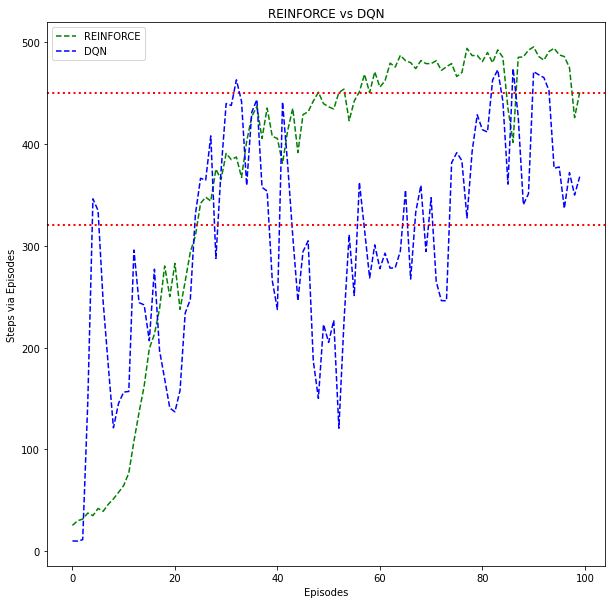

In [48]:
refined_steps = []
refined_steps_ = []

for i in range(100):
    n = 100*i
    refined_steps.append(np.mean(steps[n:n+100]))
    refined_steps_.append(np.mean(steps_[n:n+100]))

plt.figure(figsize=(10, 10))

plt.plot(refined_steps, label='REINFORCE', linestyle='--', color='green')
plt.axhline(y=450, color='r', linewidth=2, linestyle=':')
plt.plot(refined_steps_, label='DQN', linestyle='--', color='blue')
plt.axhline(y=320, color='r', linewidth=2, linestyle=':')

plt.title('REINFORCE vs DQN')
plt.xlabel('Episodes')
plt.ylabel('Steps via Episodes')

plt.savefig('steps.png')
plt.legend()
plt.show()

# Compare-rewards

In [181]:
import matplotlib as mpl

In [182]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

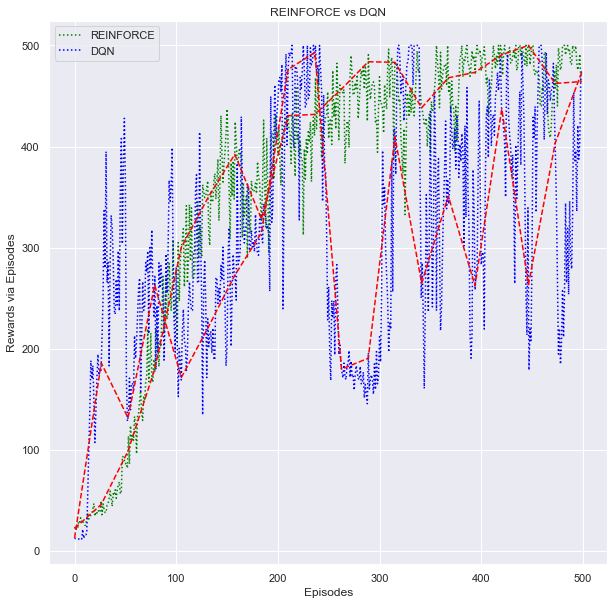

In [180]:
plt.figure(figsize=(10, 10))

plt.plot(cache, label='REINFORCE', linestyle=':', color='green')
plt.plot(cache_, label='DQN', linestyle=':', color='blue')

plt.plot(xnew, y_smooth, linestyle='--', color='red')
plt.plot(xnew_, y_smooth_, linestyle='--', color='red')


plt.title('REINFORCE vs DQN')
plt.xlabel('Episodes')
plt.ylabel('Rewards via Episodes')

plt.legend()
# plt.savefig('rewards.png')
plt.show()